In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from scipy.stats import norm, skew
from scipy.stats import boxcox
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"]=10,10
plt.rc('font', size=12) 
# import bunch of stuff for testing ....

In [2]:
data = pd.read_csv('spotify-data.csv', parse_dates = ['release_date'])

In [3]:
data.isnull().values.any() # check if there is any missing values in the data, and there is none

False

This dataset contains every weekly Hot 100 singles chart from Billboard.com from year 1921 to 2020. It contains varies feature of the songs. Our goal is to find out what features makes the song popular, and build a model for it.

In [4]:
data['release_year'] = pd.DatetimeIndex(data['release_date']).year

In [5]:
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,release_year
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921-01-01,0.0366,80.954,1921
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921-01-01,0.4150,60.936,1921
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921-01-01,0.0339,110.339,1921
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921-01-01,0.0354,100.109,1921
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921-01-01,0.0380,101.665,1921


First of all, let's look at what do those terms for each song mean before we can proceed our analysis. 
Danceability: Float value from 0 to 1. A value of 0.0 is least danceable and 1.0 is most danceable. 
Energy: Float value from 0 to 1. How energetic a song is. <br>
Key: There are 12 unique value in this variable, those are music keys which are: C, C#/Db, D, D#/Eb, E, F, F#/Gb, G,  G#/Ab, A, A#/Bb, B <br>
Loudness: How loud a song is? <br>
Mode: 1 for major, 0 for minor, categorical variable.<br>
Speechiness: Float value from 0 to 1. Probably the proportion of speech in the music. <br>
Acousticness: Float value from 0 to 1. How acoustic a song it. <br>
Instrumentalness: Float value from 0 to 1. How like the song is a instrument track/no vocal. Over 0.5 means the track is more like to be an instrumental track. <br>
Liveness: Float value from 0 to 1. How likely the song is recorded live. <br> 
Valence: Float value from 0 to 1. Higher means happier, lower means more depressed. <br>
Tempo: Beats per minute. <br>
Time signature: How many beats are in each measure of a piece of music. <br>


Extract the relevant variables we need for the analysis, remove the ones with NaN entires in them, assign categorical variables.

In [6]:
data = data[['name', 'id', 'artists', 'year', 'release_year','release_date', 'duration_ms', 
             'valence', 'acousticness', 'danceability', 'energy', 'explicit', 
             'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'popularity']]

In [7]:
data.dtypes

name                        object
id                          object
artists                     object
year                         int64
release_year                 int64
release_date        datetime64[ns]
duration_ms                  int64
valence                    float64
acousticness               float64
danceability               float64
energy                     float64
explicit                     int64
instrumentalness           float64
key                          int64
liveness                   float64
loudness                   float64
mode                         int64
speechiness                float64
tempo                      float64
popularity                   int64
dtype: object

In [8]:
data[['key','mode','explicit']] = data[['key','mode','explicit']].astype('category')

In [9]:
data['duration_ms'] = data['duration_ms'] /1000/60 # convert ms to minute
data = data.rename(columns={"duration_ms": "duration_min",})

Song length with more than 12 mins would be considered as outlier. 

In [10]:
data = data[data['duration_min']<12]

In [11]:
full = data

In [12]:
full

,name,id,artists,year,release_year,release_date,duration_min,valence,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,popularity
1,Clancy Lowered the Boom,7xPhfUan2yNtyFG0cUWkt8,['Dennis Day'],1921,1921,1921-01-01,3.008883,0.9630,0.73200,0.819,0.341,0,0.000000,7,0.1600,-12.441,1,0.4150,60.936,5
2,Gati Bali,1o6I8BglA6ylDMrIELygv1,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,1921,1921,1921-01-01,8.334367,0.0394,0.96100,0.328,0.166,0,0.913000,3,0.1010,-14.850,1,0.0339,110.339,5
3,Danny Boy,3ftBPsC5vPBKxYSee08FDH,['Frank Parker'],1921,1921,1921-01-01,3.500000,0.1650,0.96700,0.275,0.309,0,0.000028,5,0.3810,-9.316,1,0.0354,100.109,3
4,When Irish Eyes Are Smiling,4d6HGyGT8e121BsdKmw9v6,['Phil Regan'],1921,1921,1921-01-01,2.778217,0.2530,0.95700,0.418,0.193,0,0.000002,3,0.2290,-10.096,1,0.0380,101.665,2
5,Gati Mardika,4pyw9DVHGStUre4J6hPngr,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,1921,1921,1921-01-01,6.584600,0.1960,0.57900,0.697,0.346,0,0.168000,2,0.1300,-12.506,1,0.0700,119.824,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,China,0KkIkfsLEJbrcIhYsCL7L5,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",2020,2020,2020-05-29,5.028567,0.6080,0.08460,0.786,0.808,0,0.000289,7,0.0822,-3.702,1,0.0881,105.029,72
170649,Halloweenie III: Seven Days,0OStKKAuXlxA0fMH54Qs6E,['Ashnikko'],2020,2020,2020-10-23,2.510900,0.7340,0.20600,0.717,0.753,0,0.000000,7,0.1010,-6.020,1,0.0605,137.936,68
170650,AYA,4BZXVFYCb76Q0Klojq4piV,['MAMAMOO'],2020,2020,2020-11-03,3.521333,0.6370,0.10100,0.634,0.858,0,0.000009,4,0.2580,-2.226,0,0.0809,91.688,76
170651,Darkness,5SiZJoLXp3WOl3J4C8IK0d,['Eminem'],2020,2020,2020-01-17,5.619117,0.1950,0.00998,0.671,0.623,1,0.000008,2,0.6430,-7.161,1,0.3080,75.055,70


In [13]:
data = full # for machine learning model, more data is better, so use all data
# data = full[full['year']>2010] # for interpreting

In [14]:
#plt.rc('font', size=40) 
#data['energy'].hist()
#plt.title("energy")
#plt.ylabel("Count")
#plt.xlabel("Value")
#plt.show
#sns.set()

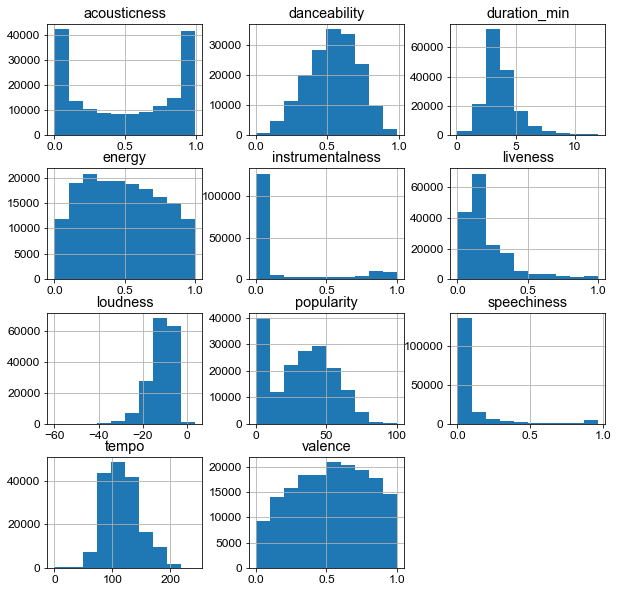

In [15]:
data.drop(['release_year','year'], axis=1).hist()
sns.set()

Finding from the histograms. High count on low speechiness indicates most popular song have litte to none speech in them. Most people like less acoustic song. More people like happier(valence). energetic(energy) song. Most of the popular songs seem to be recorded in the studio due to high coutn on low liveness values.

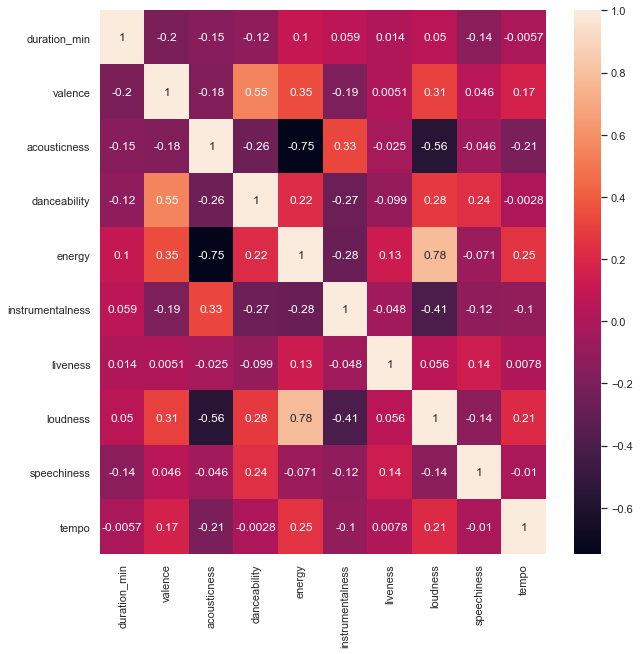

In [16]:
sns.heatmap(data.drop(['popularity','name', 'id','artists', 'year', 'release_year', 'release_date'],axis=1).corr(),annot=True)

In [17]:
clean = data

In [18]:
data[data['instrumentalness'] <= 0.01]['instrumentalness'].count()

112320

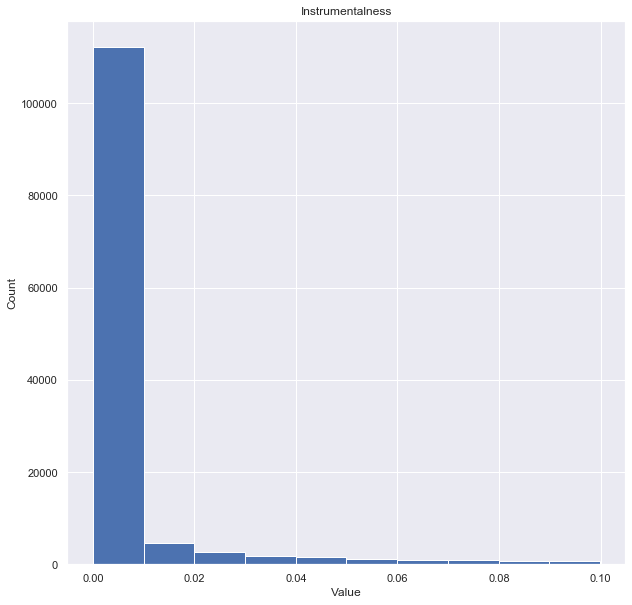

In [19]:
data[data['instrumentalness']<0.1]['instrumentalness'].hist()
plt.title("Instrumentalness")
plt.ylabel("Count")
plt.xlabel("Value")
sns.set()

Nearly all the instrumentalness values clustered together and near 0 , indicates this variable would not add much into the prediction. Keeping it might cause trouble. therefore, drop it.

In [20]:
clean = clean.drop(['instrumentalness'], axis=1)

The right skewness of 'speechiness' and 'liveness' indicating a log or squared root transformation can be performed. To avoid taking log or squared root on zero values, addig very small constant before transforming would help. This does not change the nature of the variables, because the difference bewetween each observations are being compared.

In [21]:
clean['speechiness']=np.log(clean['speechiness']+0.001)
clean['liveness']=np.log(clean['liveness']+0.001)
#clean['instrumentalness']=np.log(clean['instrumentalness']+0.001)

Using MinMaxScaler to scale values from explanatory variables to range between 0 and 1, fixing scaling issue.

In [22]:
mmscaler = MinMaxScaler()

In [23]:
scaled=mmscaler.fit_transform(clean[['speechiness','duration_min','loudness','liveness','tempo']])
clean[['speechiness','duration_min','loudness','liveness','tempo']]=scaled

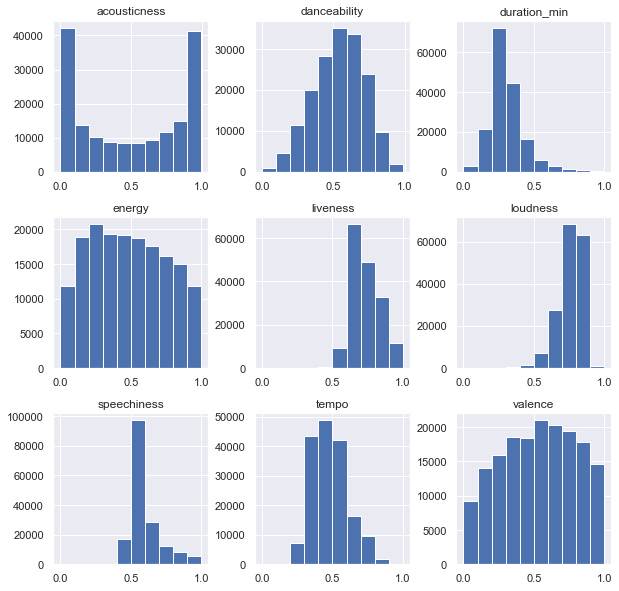

In [24]:
clean.drop(['release_year','year','popularity'], axis=1).hist()
sns.set()

Intuitively speaking, the preference of people changes as the year pass by. Setting 'year' as a categorical variable would make sense here, and also crucial to the prediction

In [25]:
clean[['year']] = clean[['year']].astype('category')

Explanatory variables.

In [26]:
X = clean.drop(['popularity','name', 'id','artists', 'release_year', 'release_date'],axis=1)

In [27]:
X.columns

Index(['year', 'duration_min', 'valence', 'acousticness', 'danceability',
       'energy', 'explicit', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo'],
      dtype='object')

Respons variables.

In [28]:
y  = clean[['popularity']] 

LinearRegression

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)
model = LinearRegression()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_valid, y_valid))

0.7491881580542012
0.7562994060920081


RandomForestRegressor

In [36]:
model = RandomForestRegressor(n_estimators= 13, max_depth=8)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_valid, y_valid))

0.8024434794747543
0.8026052390459153


In [57]:
y_true = np.array(y_valid).reshape(1,-1)
y_pred = model.predict(X_valid)
y_pred = np.array(y_pred).reshape(1,-1)

In [59]:
np.sqrt(mean_squared_error(y_true, y_pred)) #RMSE

9.720661480977801